In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Carrega a tabela imortação
imp_fert=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_cat.csv').reset_index(drop=True)
imp_fert.shape

(89785, 11)

In [2]:
imp_fert.head(1)

,year,month,ncm,Product,UF,pais,urf,kg,US$_fob,US$_freight,US$_insurance
0,1997,1,31022100,SAM,GO,23,817800,1900000,184300,19000,0


### Identifica as colunas quantitativas

In [3]:
col_quanti=['kg','US$_fob','US$_freight']
col_quanti

['kg', 'US$_fob', 'US$_freight']

### Avalia impacto e elimina registros com quantidade igual a zero

In [4]:
# Avalia impacto na eliminação de registros com quantidade zero
for q in col_quanti:
    print(f"{q} possui {round(100*imp_fert[imp_fert[q]==0].shape[0]/imp_fert.shape[0],1)} % dos registros com valor igual a zero.")

kg possui 0.0 % dos registros com valor igual a zero.
US$_fob possui 0.0 % dos registros com valor igual a zero.
US$_freight possui 0.3 % dos registros com valor igual a zero.


In [5]:
for q in col_quanti:
    par=imp_fert[imp_fert[q]==0][[x for x in col_quanti if x not in [q]]].sum()
    tot=imp_fert[imp_fert[q]!=0][[x for x in col_quanti if x not in [q]]].sum()
    print('Qdo ',q,'= 0:')
    print(f"{100*(par/tot)} % do total.")
    print()

Qdo  kg = 0:
US$_fob        2.237782e-06
US$_freight    6.689952e-09
dtype: float64 % do total.

Qdo  US$_fob = 0:
kg             0.0
US$_freight    0.0
dtype: float64 % do total.

Qdo  US$_freight = 0:
kg         0.000108
US$_fob    0.000101
dtype: float64 % do total.



In [6]:
# Seleciona colunas para descate de zero
col_quanti=[x for x in col_quanti if x not in ['VL_SEGURO']]
col_quanti

['kg', 'US$_fob', 'US$_freight']

In [7]:
# Descarta registros com valor igual a zero
for c in col_quanti:
    imp_fert=imp_fert[imp_fert[c]>0]

sns.displot(kind='kde',data=imp_fert.sort_values('Product'),x='kg',col='Product',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False,sharex=False))

plt.show()

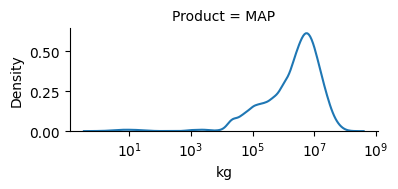

In [8]:
sns.displot(kind='kde',data=imp_fert[imp_fert.Product=='MAP'].sort_values('Product'),x='kg',col='Product',height=2,aspect=2,\
            log_scale=True)

plt.savefig('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/graphs/fertilizers_imports0.png')
plt.show()

## Clusteriza NCM

In [9]:
imp_fert['log_kg']=np.log10(imp_fert.kg)
imp_fert['log_fob']=np.log10(imp_fert['US$_fob'])
imp_fert['log_frete']=np.log10(imp_fert['US$_freight'])
imp_fert['cif_kg']=(imp_fert['US$_fob']+imp_fert['US$_freight'])/imp_fert.kg
imp_fert['fob_kg']=(imp_fert['US$_fob'])/imp_fert.kg

In [10]:
n_cluster_list=[1,3,3,
                3,2,1,
                6,2,2,
                5,3,2,
                2,3,2,
                2,2,4,
                1,3,2,
                5,1,1,
                1,2,4]
ncm_list=imp_fert['Product'].drop_duplicates().sort_values().values
d=dict(zip(ncm_list,n_cluster_list))

In [11]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/clusteriza_ncm.ipynb'

** Função clusteriza_ncm(imp_fert, n_clusters=4, cols_base=['s_log_kg','s_log_fob']) disponível **


In [12]:
q=pd.DataFrame()
for n in ncm_list:
    t=imp_fert[imp_fert.Product==n]
    t=clusteriza_ncm(t,n_clusters=d[n],cols_base=['log_kg','log_fob','log_frete','cif_kg','fob_kg'])
    q=pd.concat([q,t])

In [13]:
imp_fert=q

In [14]:
imp_fert[(imp_fert.Product=='MAP')&(imp_fert.km==1)].kg.min()

np.int64(987)

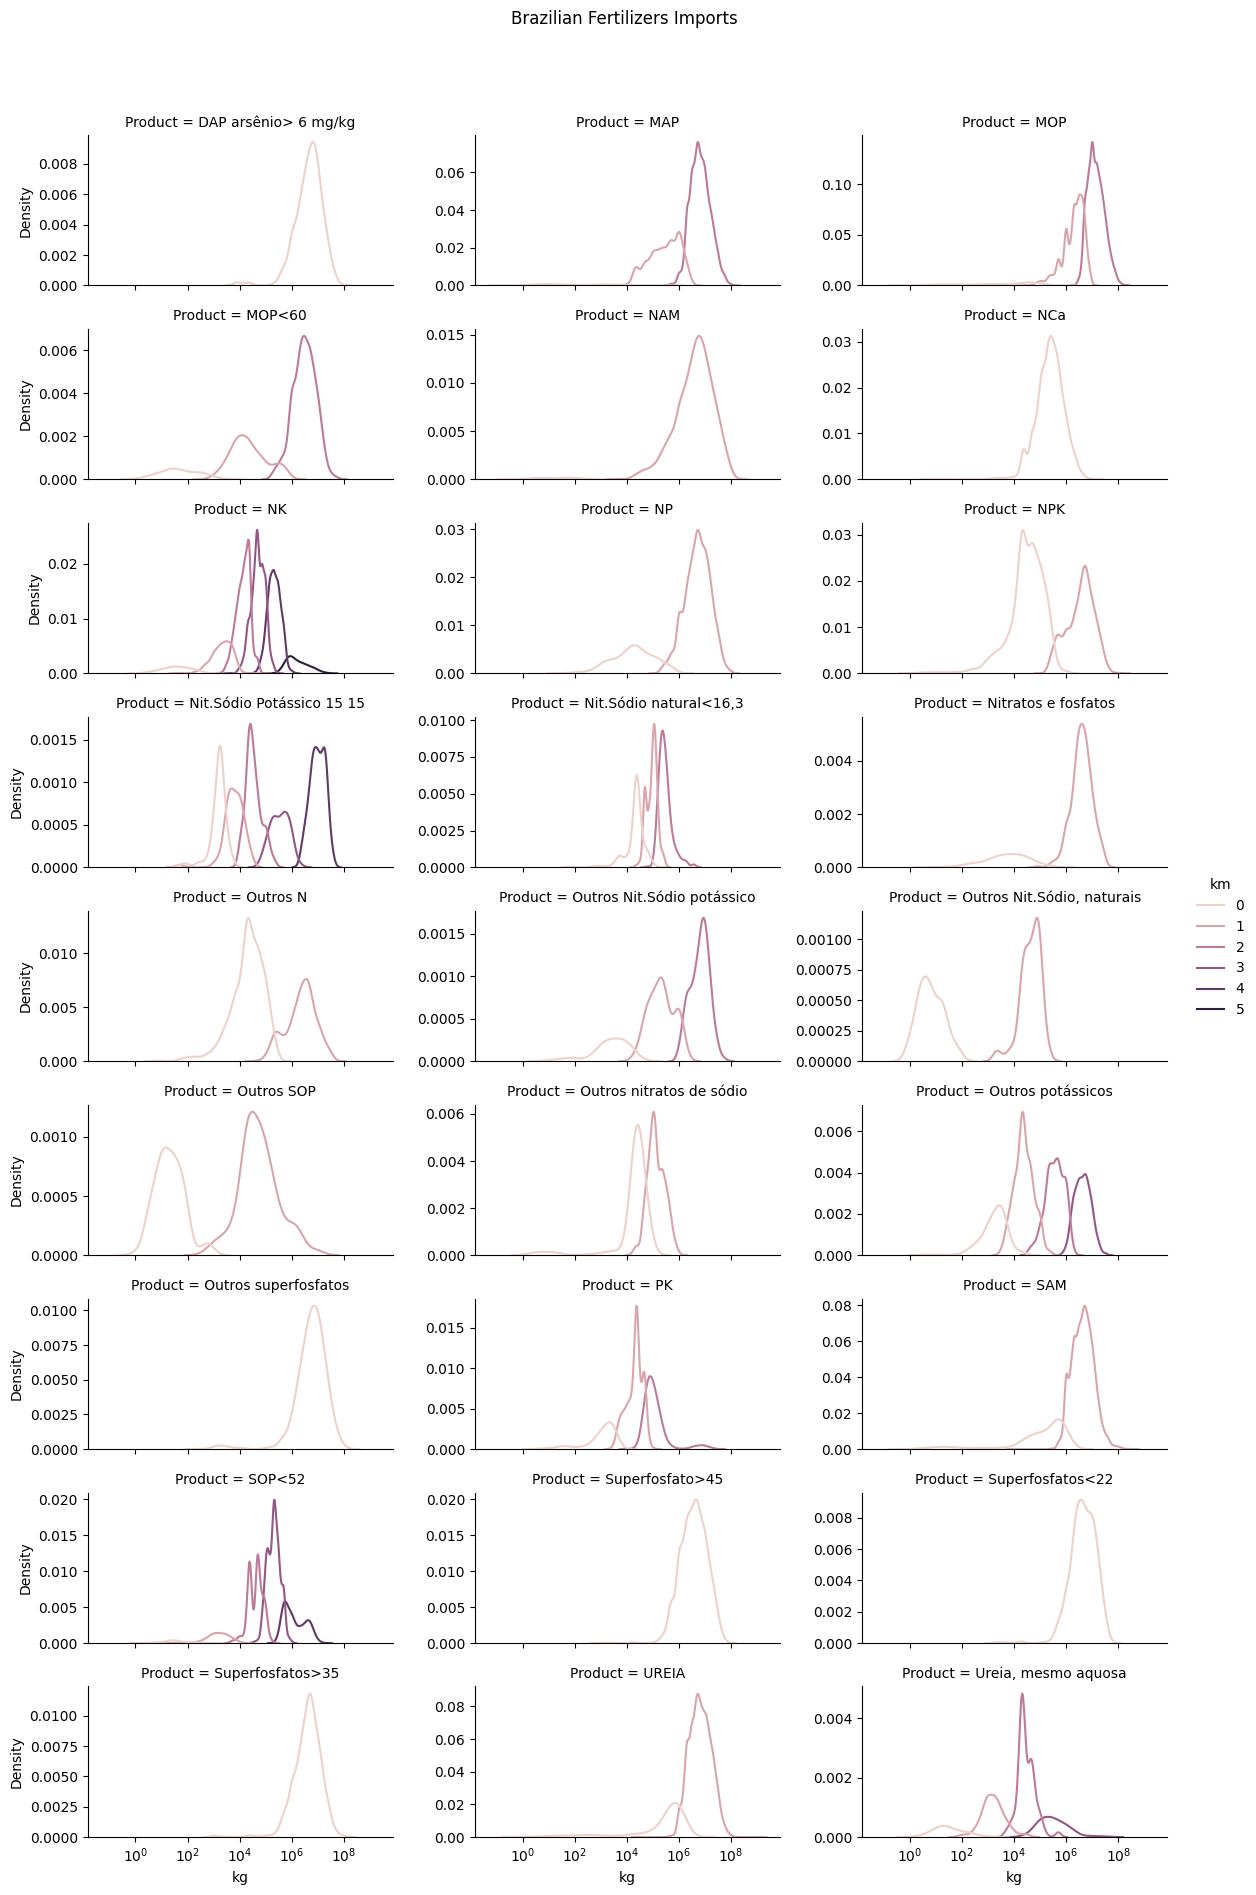

In [15]:
sns.displot(kind='kde', data=imp_fert, x='kg', col='Product', hue='km', col_wrap=3, height=2, aspect=2,\
            log_scale=True, facet_kws=dict(sharey=False)).fig.suptitle('Brazilian Fertilizers Imports', y=1.05)

#plt.savefig('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/graphs/fertilizers_imports.png')
plt.show()

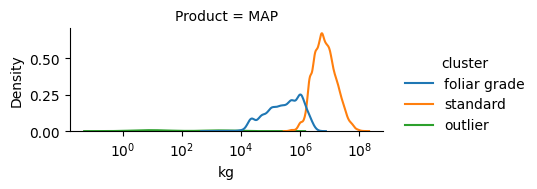

In [16]:
dict_km={0:'outlier',1:'foliar grade',2:'standard'}
data=imp_fert[(imp_fert.Product=='MAP')]
data['cluster']=data.km.map(dict_km)
sns.displot(kind='kde', data=data, x='kg', col='Product', hue='cluster',\
             height=2, aspect=2, log_scale=True)

plt.savefig('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/graphs/fertilizers_imports.png')
plt.show()

### Corrige outliers através do preço

Confere maior registro de peso:

In [17]:
imp_fert[imp_fert.kg==imp_fert.kg.max()]

,s_fob_kg,s_cif_kg,s_log_frete,s_log_fob,s_log_kg,year,month,ncm,Product,UF,...,kg,US$_fob,US$_freight,US$_insurance,log_kg,log_fob,log_frete,cif_kg,fob_kg,km
1118,0.0,0.0,0.811266,0.852084,1.0,2003,8,31021010,UREIA,BA,...,1418071545,5604808,293995,0,9.151698,6.748561,5.46834,0.00416,0.003952,1


Confere a soma geral

In [18]:
round(imp_fert[['kg','US$_fob']].sum()/10**9)

kg         557.0
US$_fob    178.0
dtype: float64

Carrega função para correção via preço

In [19]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/corr_kg_fob_via_preço.ipynb'
q=pd.DataFrame()
z=2
k=0
f=0
for ncm in imp_fert.ncm.unique():
    for km in imp_fert.km.unique():
        t=imp_fert[(imp_fert.ncm==ncm)&(imp_fert.km==km)]
        t1, len_err_kg, len_err_fob=corr_kg_fob_via_preço(t,z)
        q=pd.concat([q,t1])
        k+=len_err_kg
        f+=len_err_fob

print(f"Através do preço, foram corrigidos {k} registros de kg e {f} registros de valor fob, que estavam a mais de {z} vezes \
o desvio padrão\nde distância da média (z score).")

imp_fert=q.copy()

** Função corr_kg_fob_via_preço(comex_df,z=3) disponível **
Através do preço, foram corrigidos 2233 registros de kg e 1887 registros de valor fob, que estavam a mais de 2 vezes o desvio padrão
de distância da média (z score).


Confere maior registro de peso:

In [20]:
imp_fert[imp_fert.kg==imp_fert.kg.max()]

,s_fob_kg,s_cif_kg,s_log_frete,s_log_fob,s_log_kg,year,month,ncm,Product,UF,...,qd_dif_log_fob,std_log_fob,z_score_log_fob,dif_z_score,mean_dif_z_score,qd_dif_dif_z_score,std_dif_z_score,z_score_dif_z_score,preço,kg_err
9694,0.000686,0.000274,0.97953,0.97788,1.0,2023,10,31022100,SAM,MT,...,3.995293,0.468446,4.266924,0.305913,2.296403e-15,0.093583,0.475895,0.642815,NaN,NaN


Confere a soma geral

In [21]:
imp_fert[['kg','US$_fob']].sum()/10**9

kg         552.676071
US$_fob    174.995724
dtype: float64

In [22]:
imp_fert.columns

Index(['s_fob_kg', 's_cif_kg', 's_log_frete', 's_log_fob', 's_log_kg', 'year',
       'month', 'ncm', 'Product', 'UF', 'pais', 'urf', 'kg', 'US$_fob',
       'US$_freight', 'US$_insurance', 'log_kg', 'log_fob', 'log_frete',
       'cif_kg', 'fob_kg', 'km', 'mean_log_kg', 'qd_dif_log_kg', 'std_log_kg',
       'z_score_log_kg', 'mean_log_fob', 'qd_dif_log_fob', 'std_log_fob',
       'z_score_log_fob', 'dif_z_score', 'mean_dif_z_score',
       'qd_dif_dif_z_score', 'std_dif_z_score', 'z_score_dif_z_score', 'preço',
       'kg_err'],
      dtype='object')

In [23]:
imp_fert=imp_fert[[ 'year','month', 'ncm', 'Product', 'UF', 'pais', 'urf', 'kg', 'US$_fob',\
       'US$_freight', 'US$_insurance','cif_kg', 'fob_kg', 'km', 'preço']]

In [24]:
imp_fert.to_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_quanti.csv',index=False)